# Visualizaci√≥n del Impacto del Cambio Clim√°tico en la Temperatura Global

Este notebook analiza las tendencias de temperatura a nivel global y regional, explorando patrones de calentamiento y su relaci√≥n con otros indicadores clim√°ticos.

## Configuraci√≥n del Entorno

Importamos las bibliotecas necesarias y establecemos la conexi√≥n con la base de datos.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymysql
from dotenv import load_dotenv
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

# Configuraci√≥n visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Cargar variables de entorno y conectar a la base de datos
load_dotenv()
conn = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)

## 0. MApa de relacion de temperatura desde 1990 hasta 2019 en todos los paises del mundo

En estos mapas se puede observar como ha aumentado o reducido la temeperatiura en todos los paises del mundo y en cuales dichos cambios han sido mas bruscos

C:\Users\jcall\AppData\Local\Temp\ipykernel_11204\2590277418.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_temp = pd.read_sql(query_temp, conn)


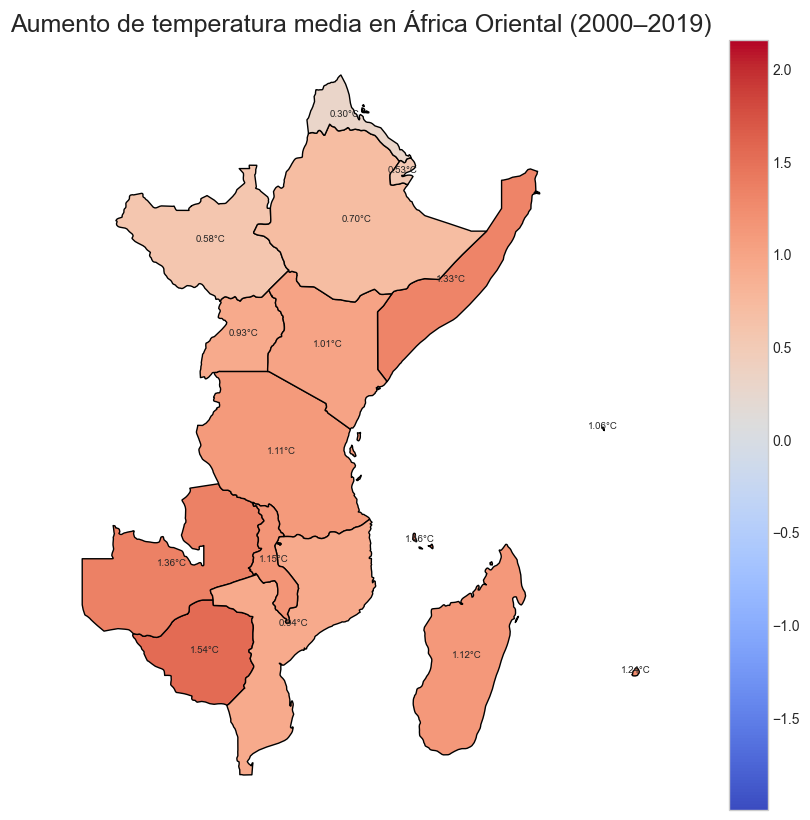

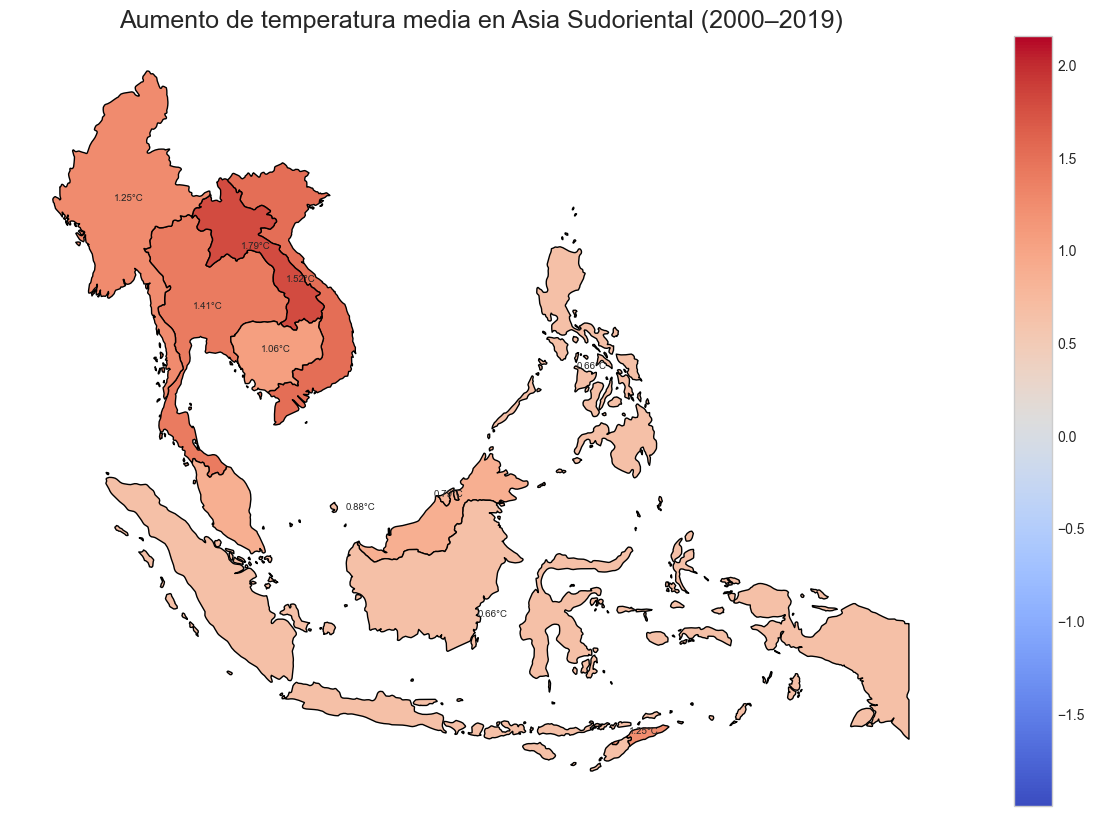

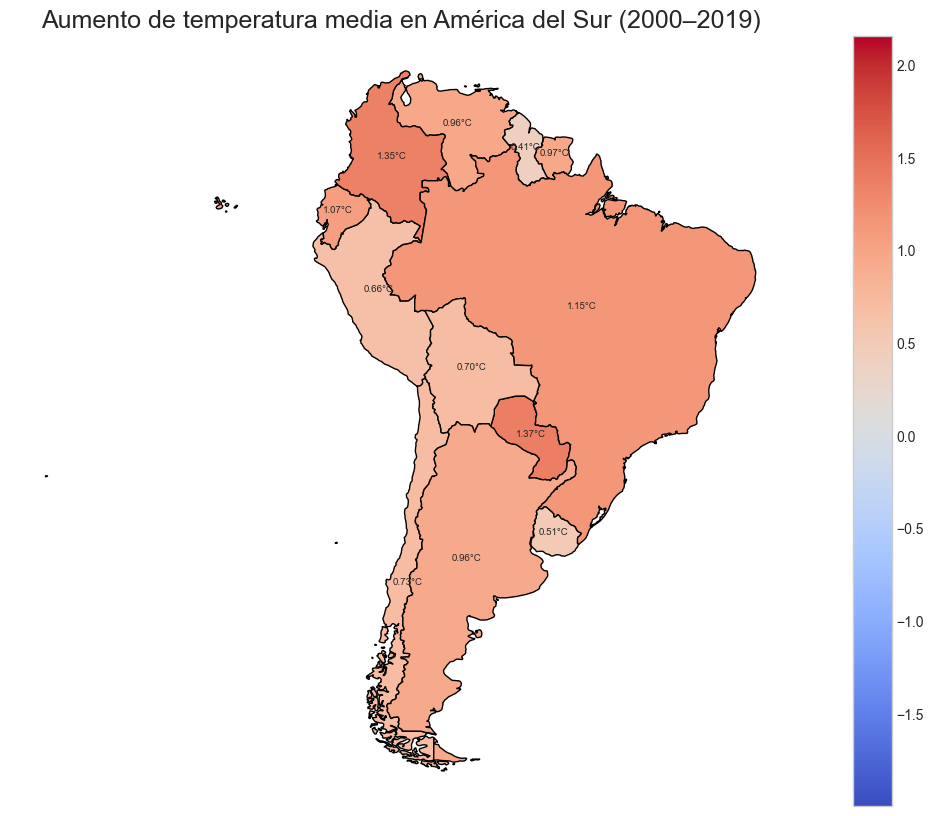

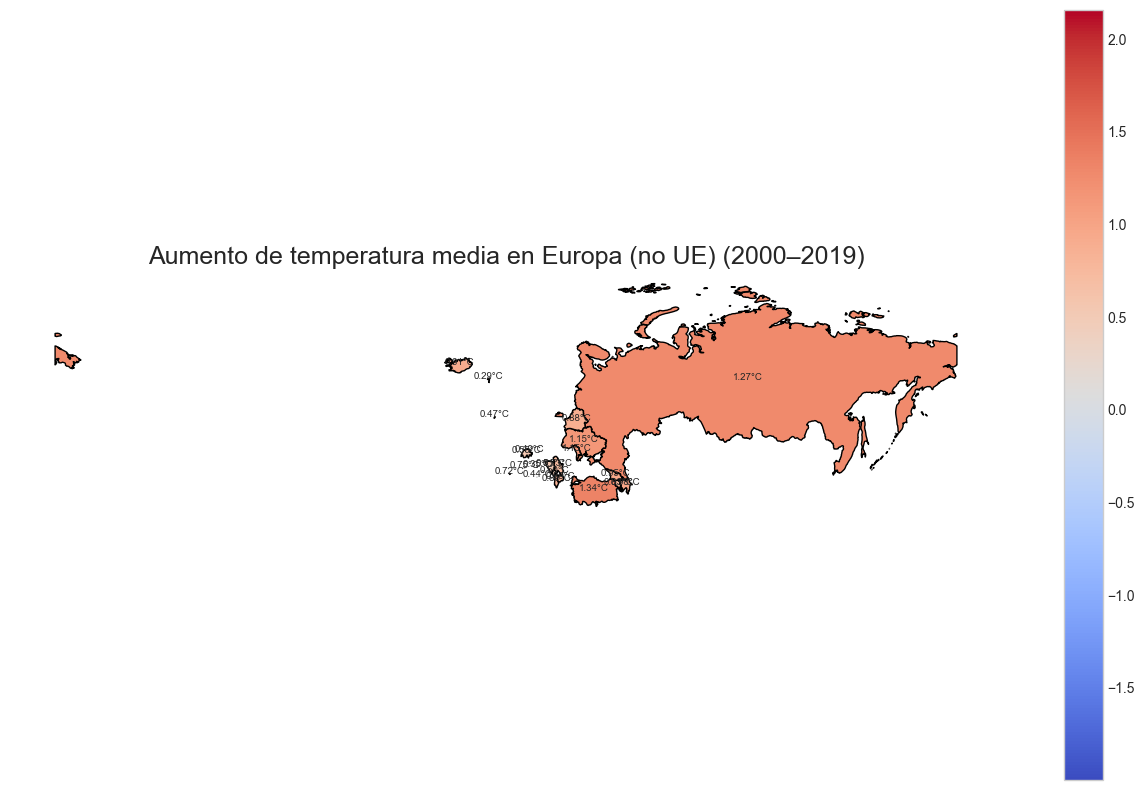

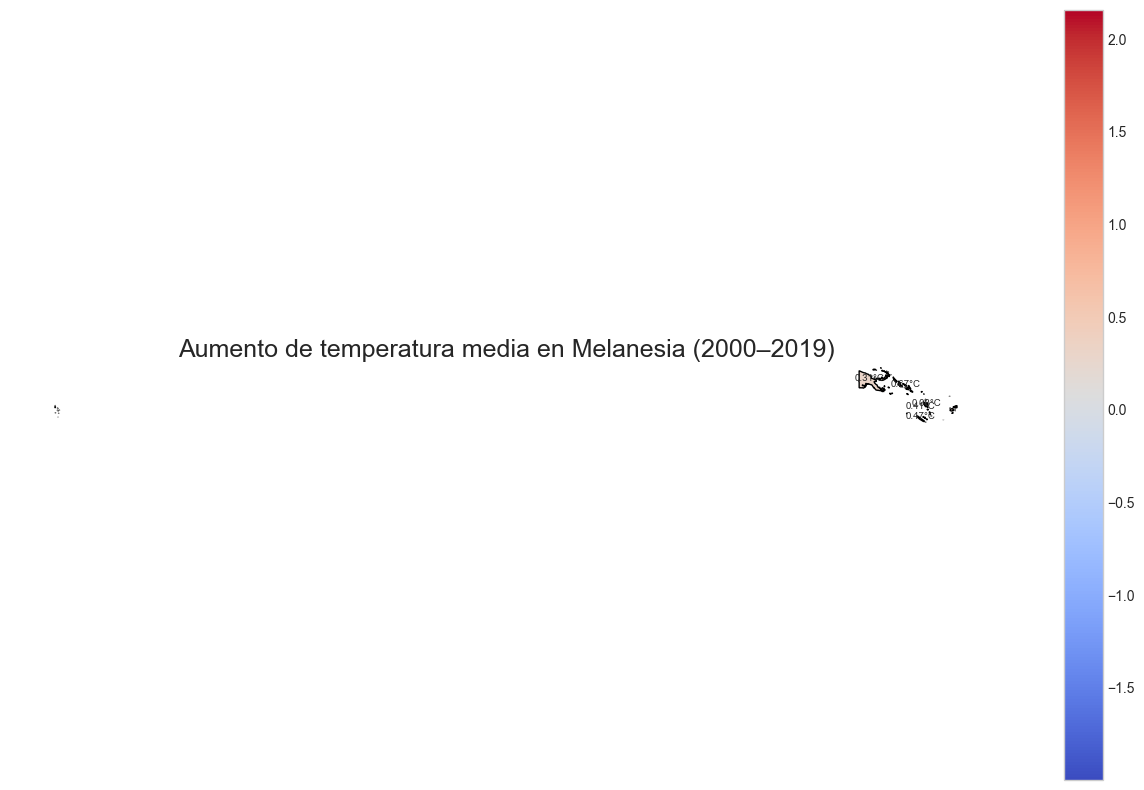

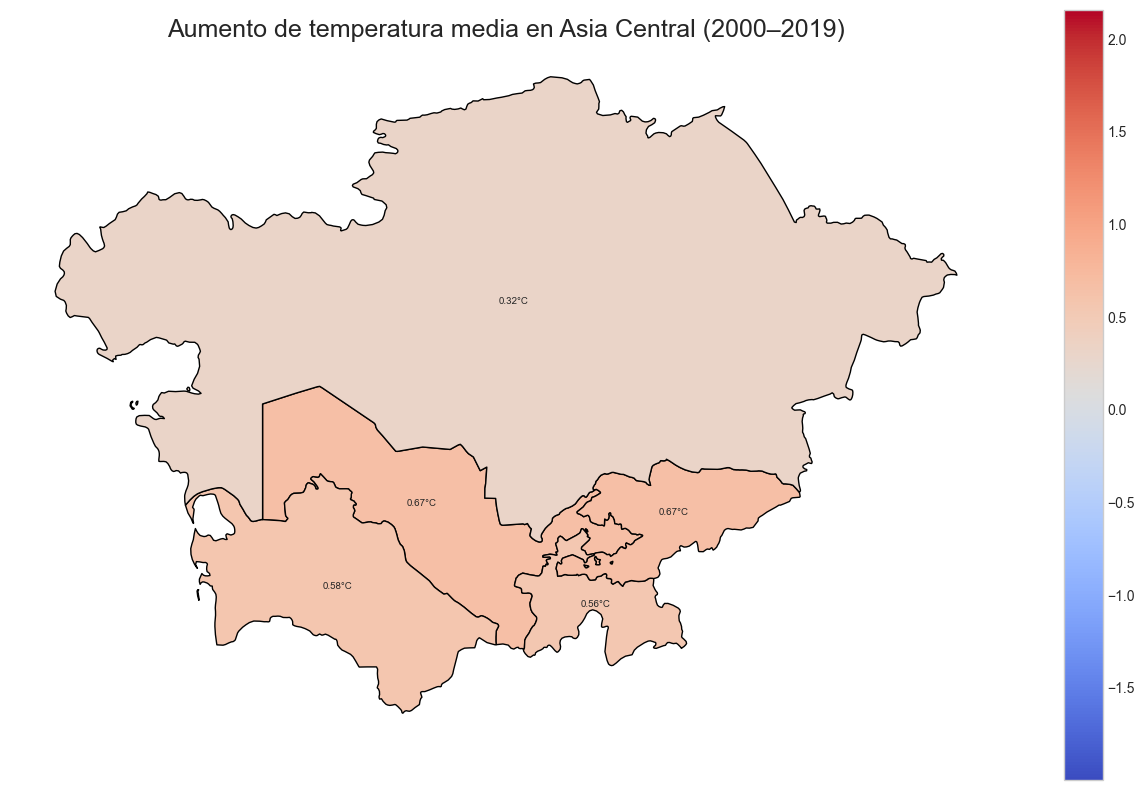

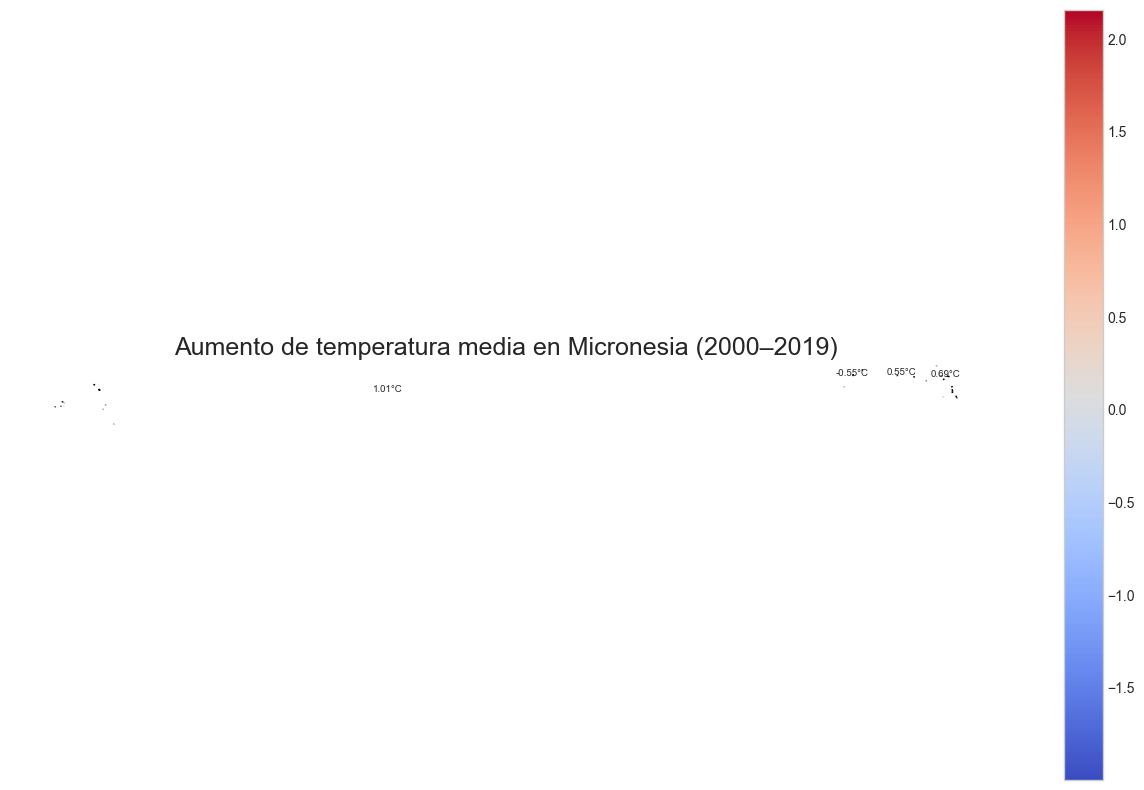

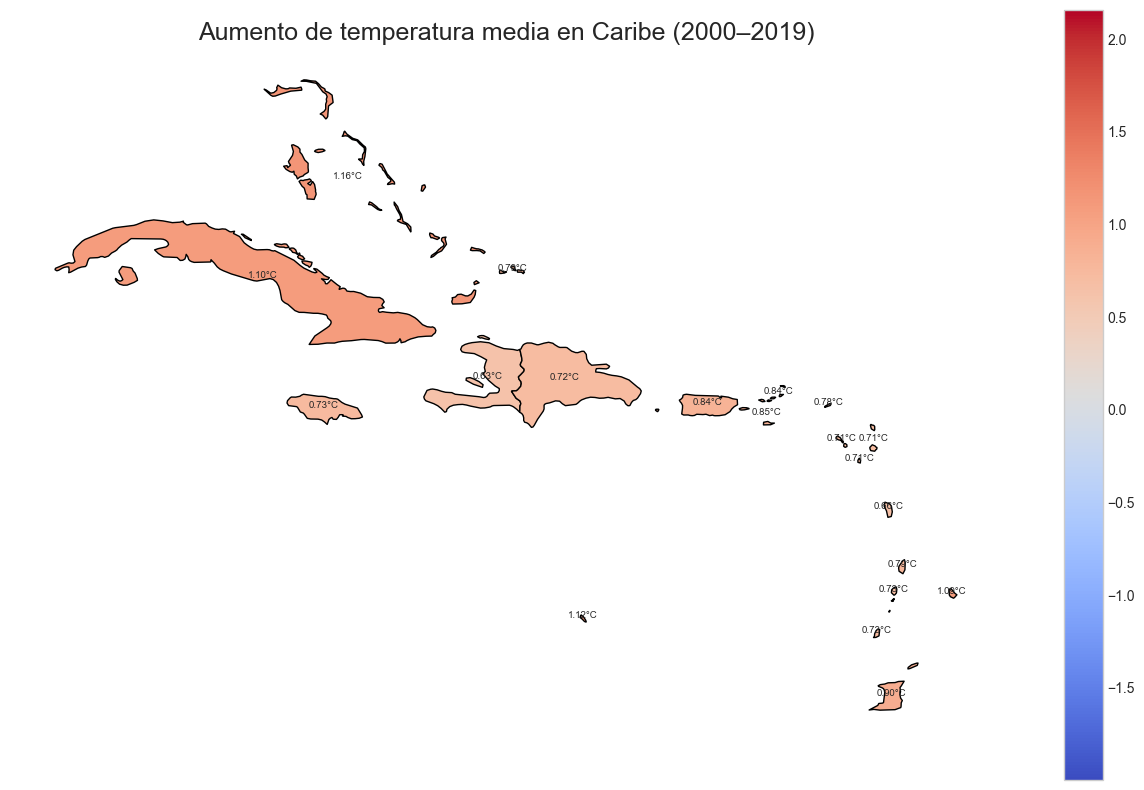

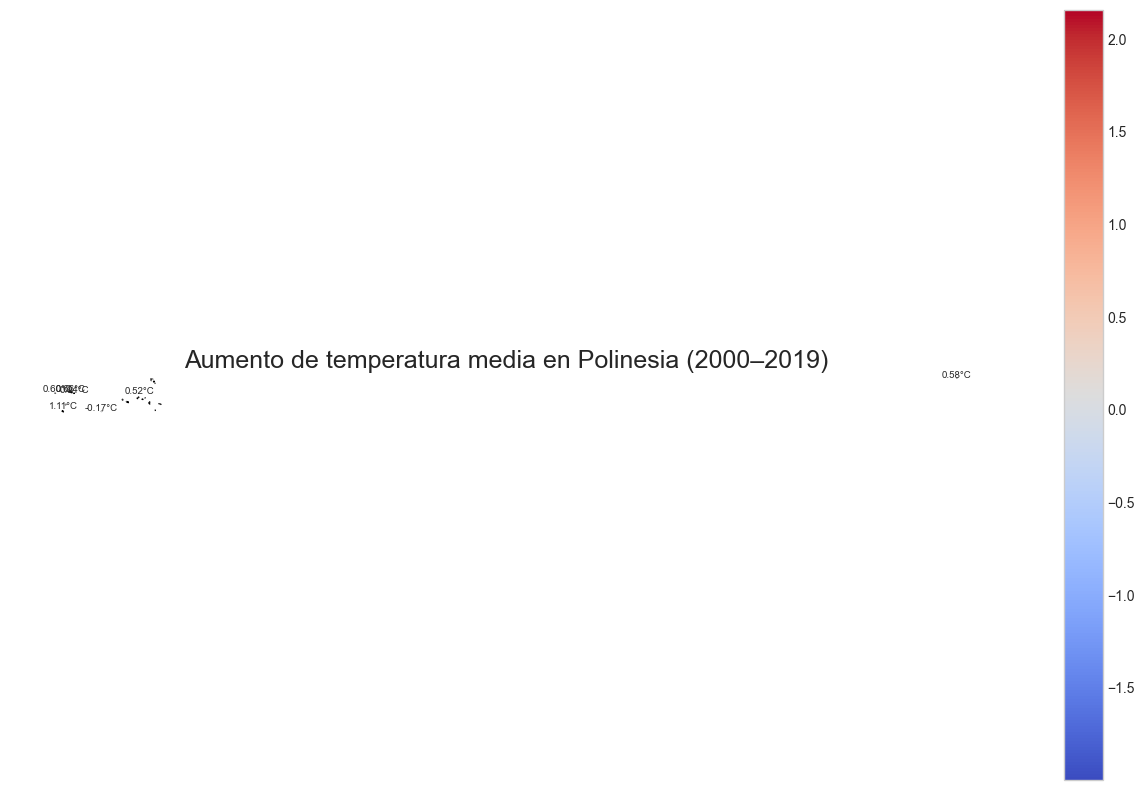

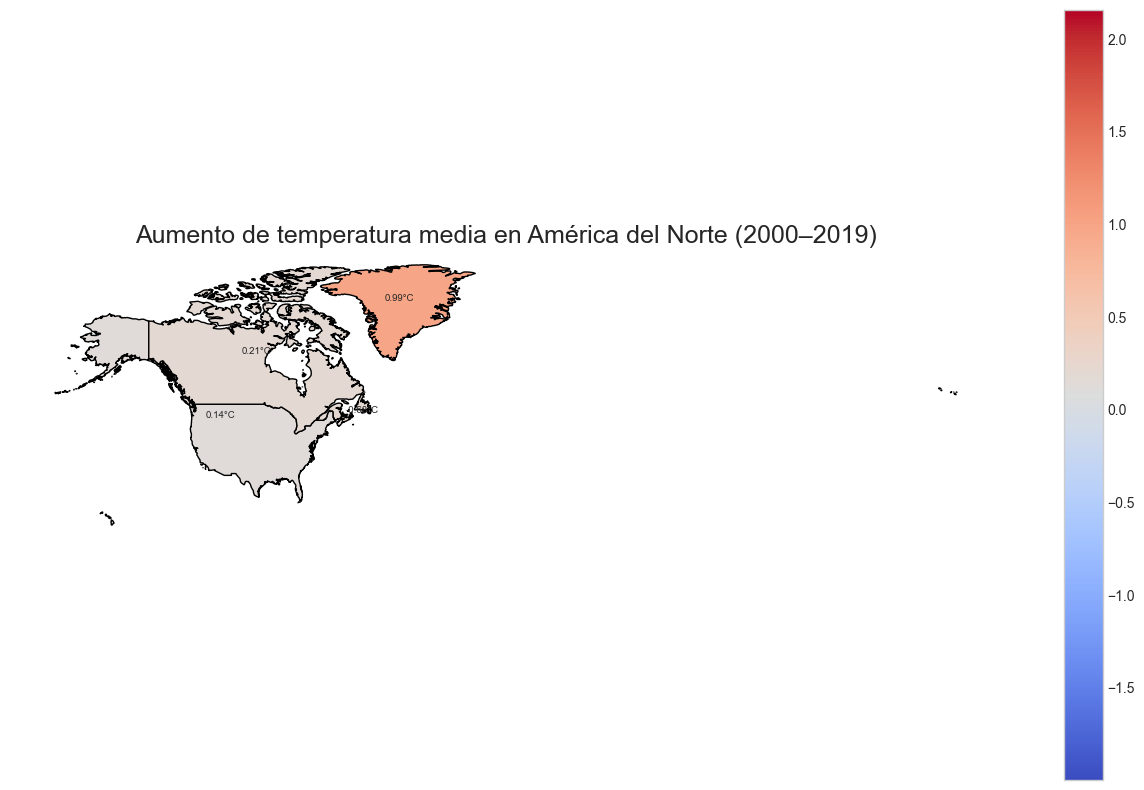

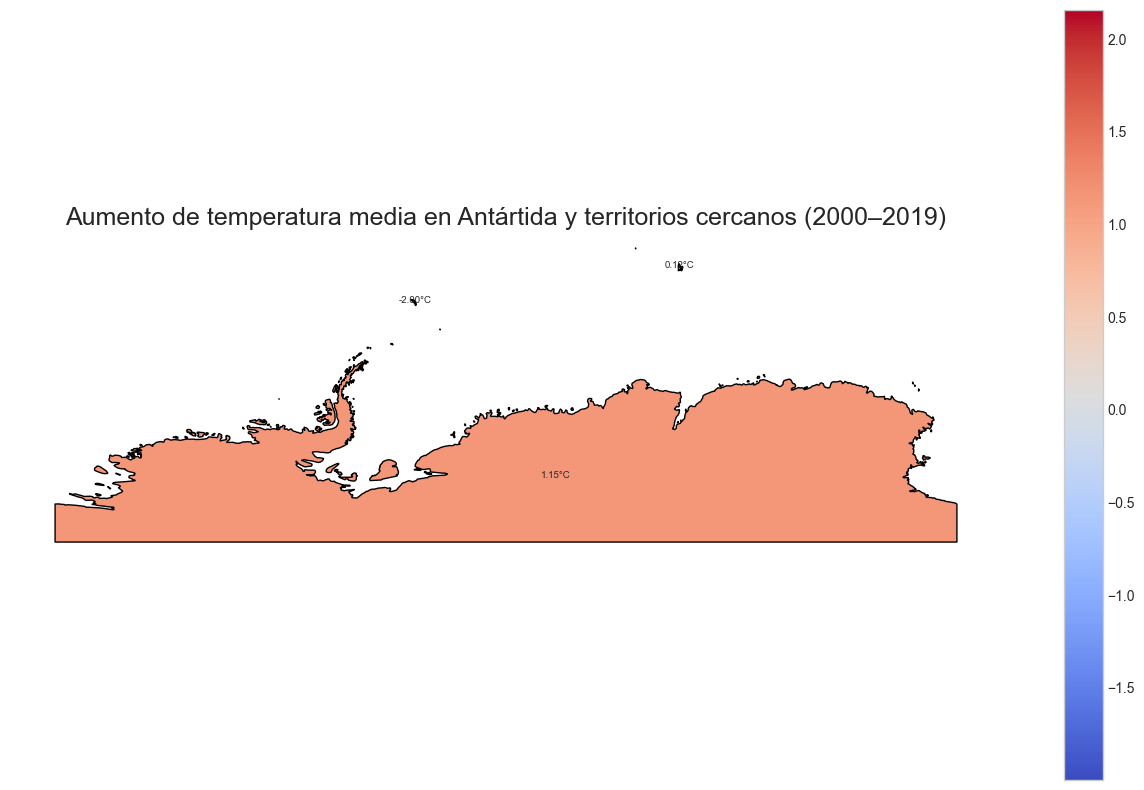

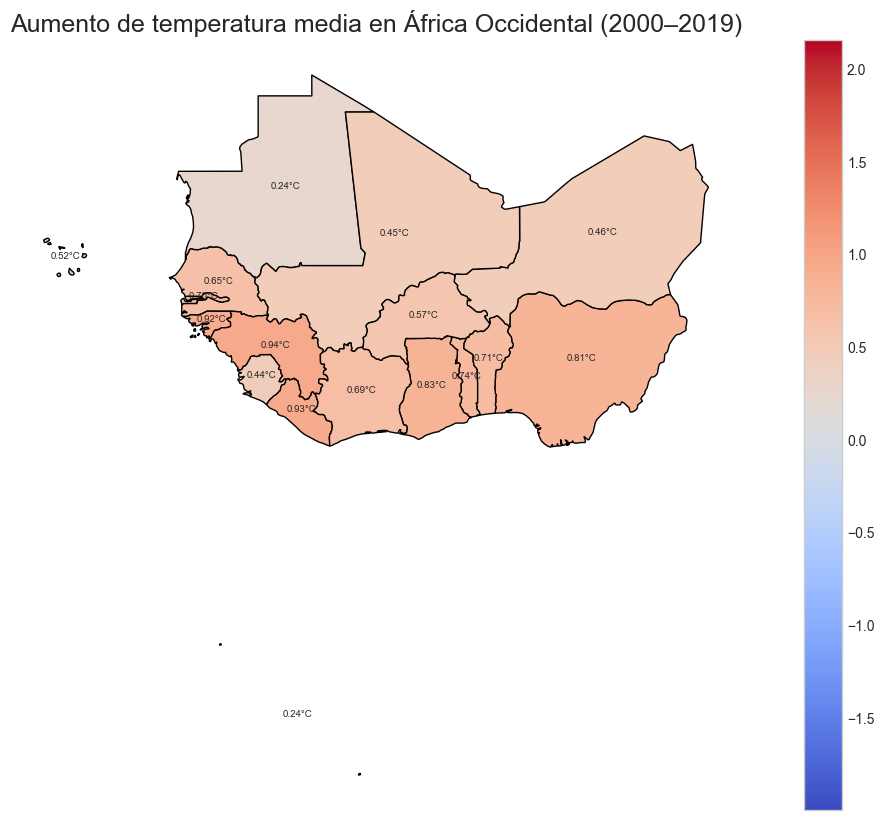

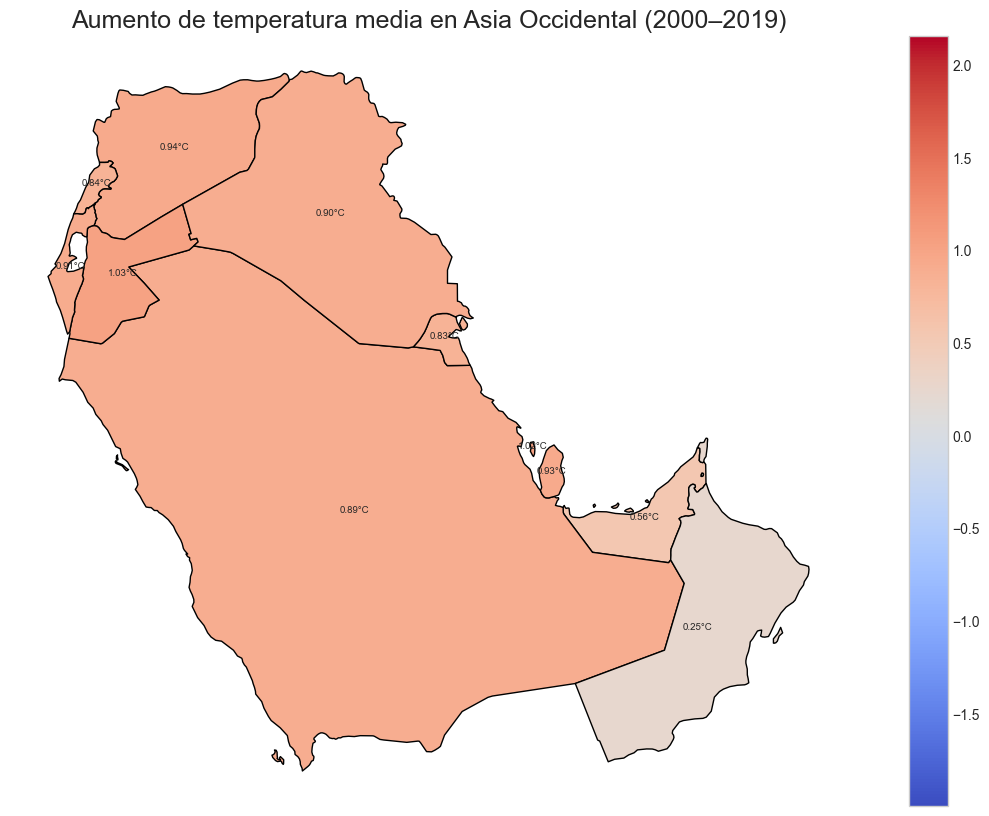

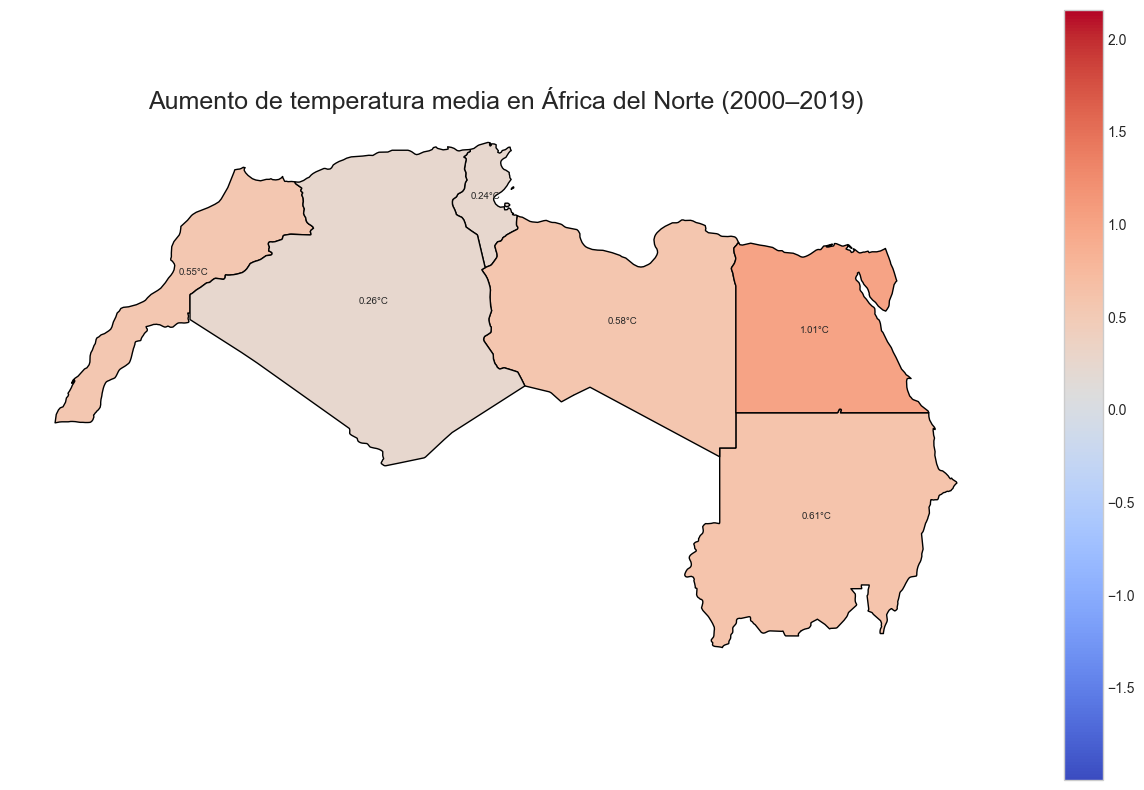

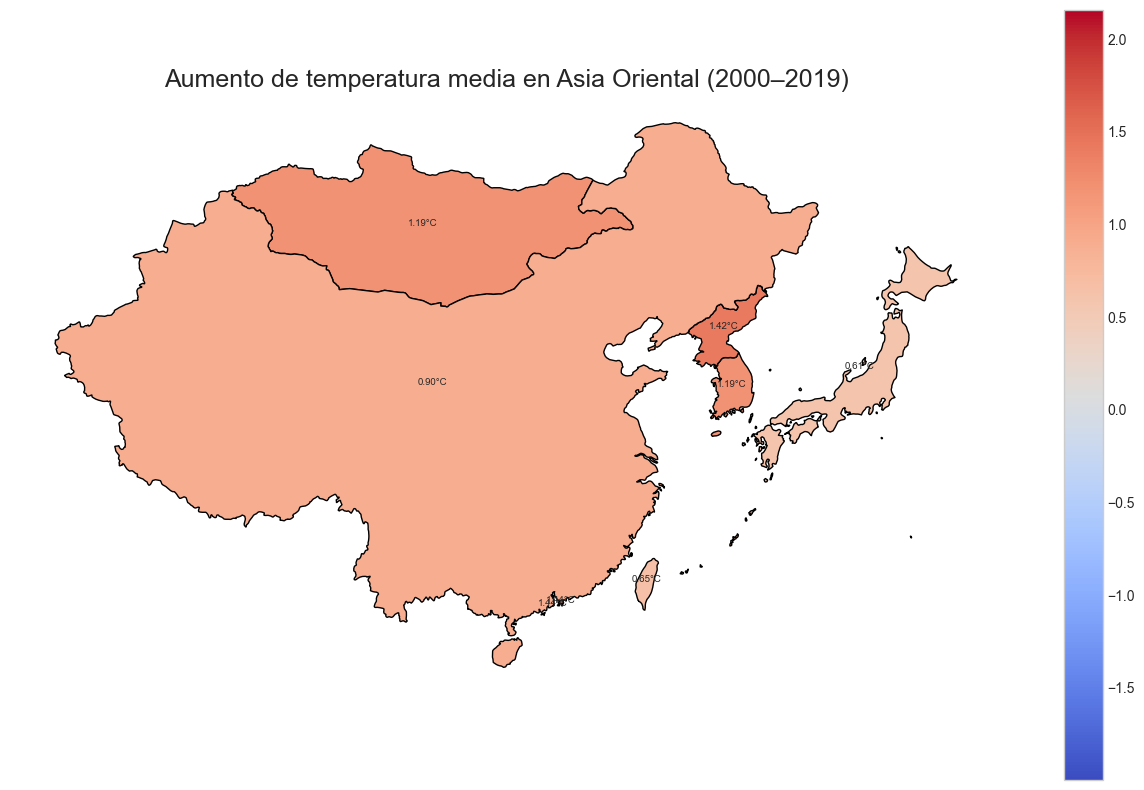

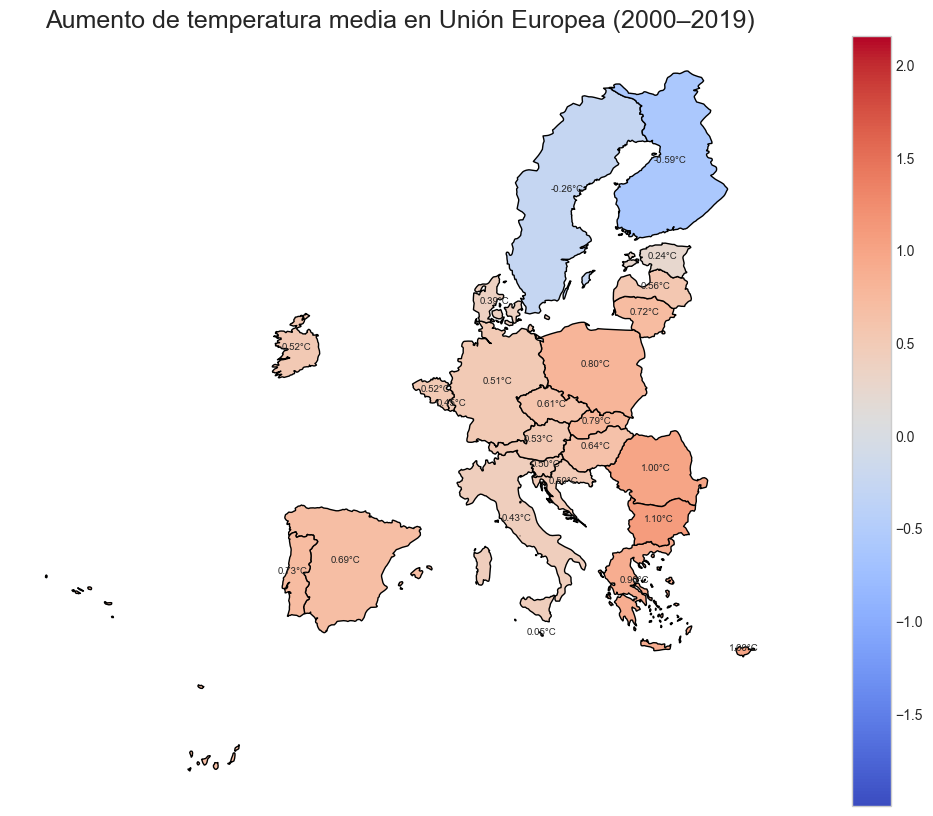

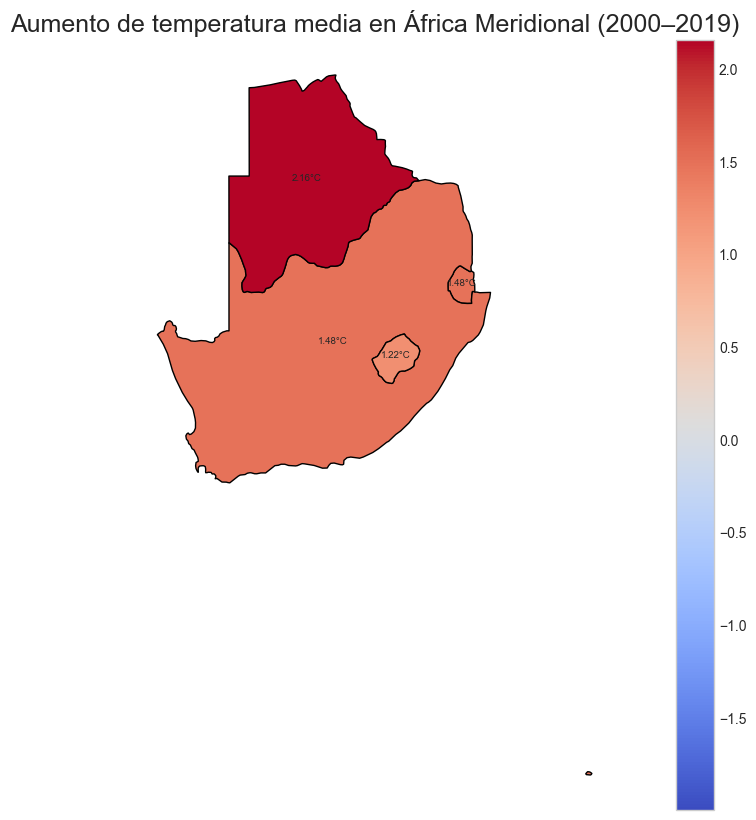

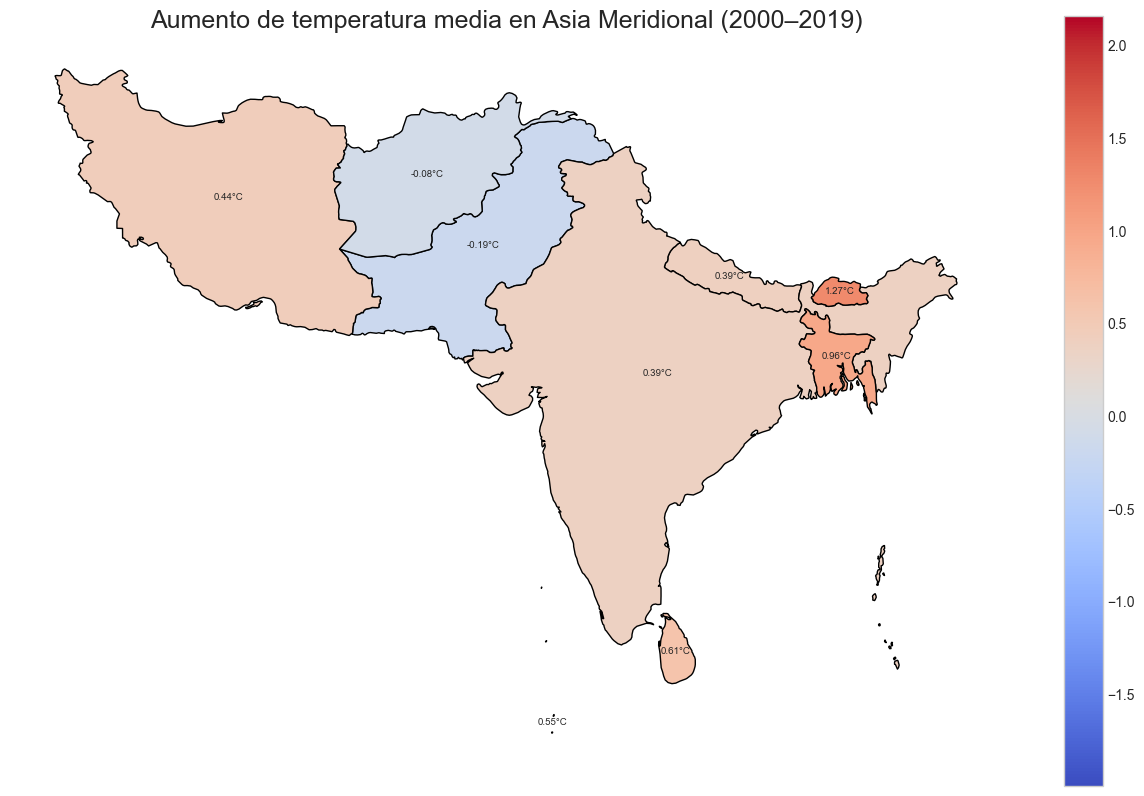

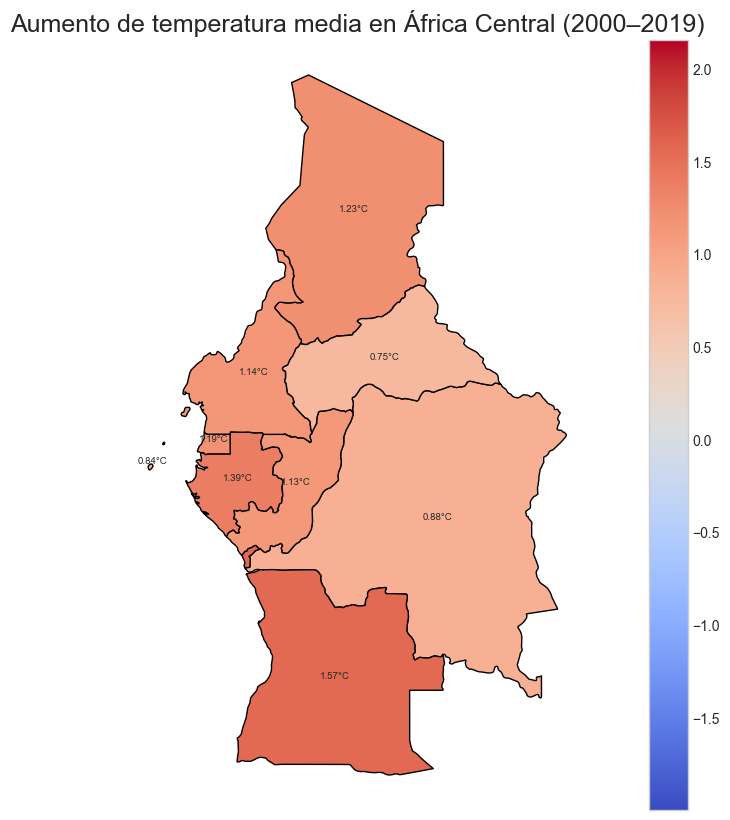

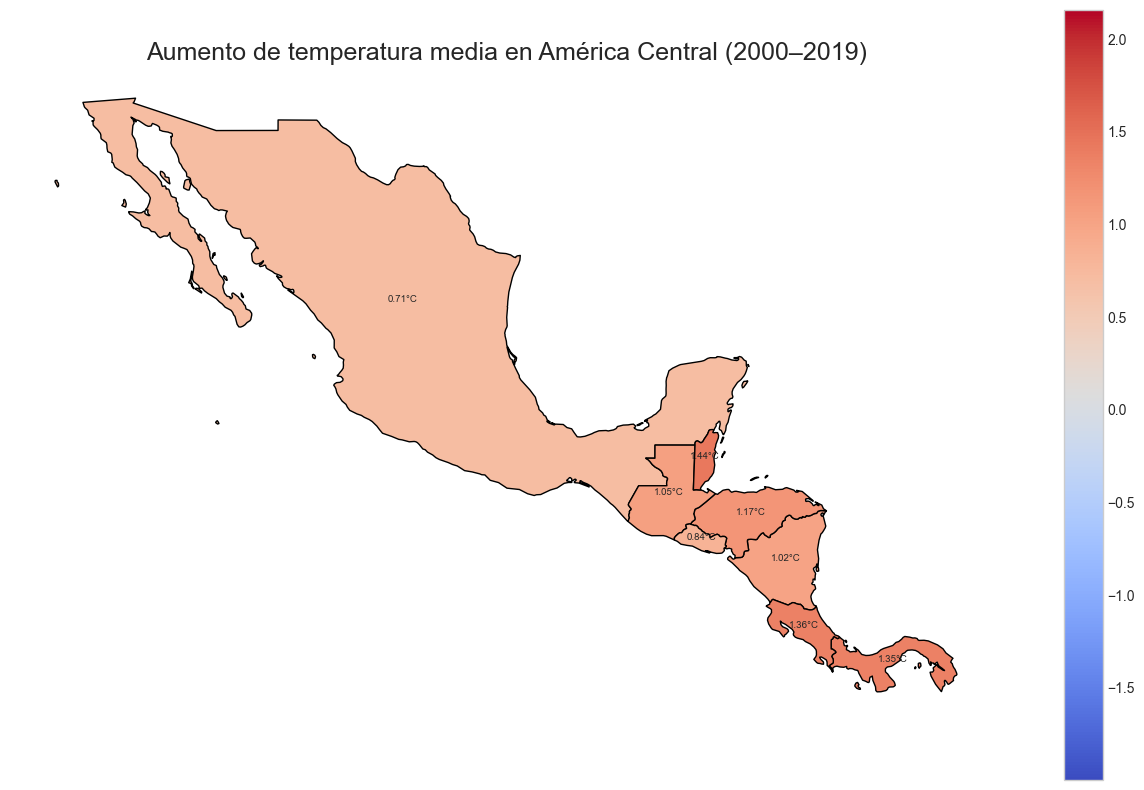

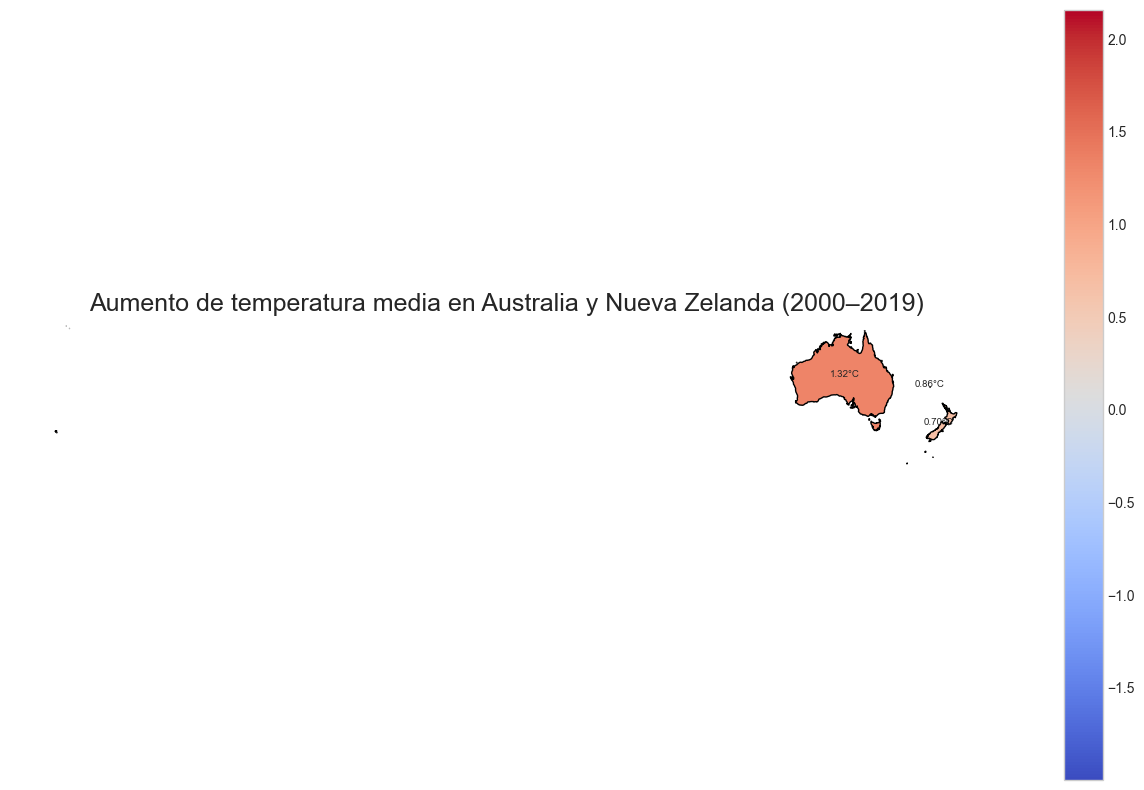

In [ ]:

query_temp = """
SELECT 
    h.anio,
    p.codigo AS pais_codigo,
    p.nombre AS pais_nombre,
    sc.nombre AS subcontinente,
    c.nombre AS continente,
    h.valor AS temperatura
FROM hechos h
JOIN paises p ON h.pais_id = p.codigo
JOIN indicadores i ON h.indicador_id = i.id
JOIN subcontinentes sc ON p.subcontinente_id = sc.id
JOIN continentes c ON sc.continente_id = c.id
WHERE i.id = 1
  AND h.anio IN (2000, 2019)
ORDER BY continente, subcontinente, pais_nombre, h.anio;
"""

# ========================
# üì• Ejecutar y preparar datos
# ========================
df_temp = pd.read_sql(query_temp, conn)

# Pivot: una fila por pa√≠s, con columnas para a√±o 2000 y 2019
df_temp_pivot = df_temp.pivot_table(
    index=["pais_codigo", "pais_nombre", "continente", "subcontinente"],
    columns="anio",
    values="temperatura"
).reset_index()

# Renombrar columnas
df_temp_pivot.rename(columns={
    2000: "temp_2000",
    2019: "temp_2019"
}, inplace=True)

# Calcular aumento de temperatura
df_temp_pivot = df_temp_pivot.dropna(subset=["temp_2000", "temp_2019"])
df_temp_pivot["aumento_temp"] = df_temp_pivot["temp_2019"] - df_temp_pivot["temp_2000"]

# ISO3 para merge
import pycountry
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_temp_pivot["iso_a3"] = df_temp_pivot["pais_codigo"].apply(iso2_to_iso3)
df_temp_pivot = df_temp_pivot[df_temp_pivot["iso_a3"].notna()]

# ========================
# üåç Cargar shapefile y merge
# ========================
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

# Merge
map_data = world.merge(df_temp_pivot, how="inner", left_on="ISO_A3", right_on="iso_a3")
map_data = map_data[map_data["geometry"].notna()]

# ========================
# üó∫Ô∏è Mapas por subcontinente con escala global
# ========================
subcontinentes = map_data["subcontinente"].unique()

# Escala fija: min y max globales
vmin = map_data["aumento_temp"].min()
vmax = map_data["aumento_temp"].max()

for subcont in subcontinentes:
    subset = map_data[map_data["subcontinente"] == subcont]

    if subset.empty:
        continue

    ax = subset.plot(
        column="aumento_temp",
        cmap="coolwarm",
        legend=True,
        figsize=(16, 10),
        edgecolor="black",
        vmin=vmin,
        vmax=vmax,
        missing_kwds={"color": "lightgrey"}
    )

    plt.title(f"Aumento de temperatura media en {subcont} (2000‚Äì2019)", fontsize=18)

    for idx, row in subset.iterrows():
        if row["geometry"].centroid.is_empty:
            continue
        x, y = row["geometry"].centroid.coords[0]
        plt.text(x, y, f"{row['aumento_temp']:.2f}¬∞C", fontsize=7, ha='center')

    plt.axis("off")
    plt.show()


## 1. Resumen de Datos de Temperatura Disponibles

Primero, exploramos la cantidad de datos de temperatura disponibles por pa√≠s y a√±o para tener una visi√≥n general de la cobertura de nuestro dataset.

In [3]:
# Consulta para obtener la cantidad de datos por pa√≠s y a√±o para temperaturas
query_resumen = """
SELECT 
    COUNT(DISTINCT p.codigo) AS num_paises,
    MIN(h.anio) AS anio_min,
    MAX(h.anio) AS anio_max,
    COUNT(DISTINCT h.anio) AS num_anios,
    COUNT(*) AS num_registros
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'temperaturas';
"""

df_resumen = pd.read_sql(query_resumen, conn)

# Mostrar resumen
print("Resumen de datos de temperatura:")
print(f"N√∫mero de pa√≠ses: {df_resumen['num_paises'].values[0]}")
print(f"Rango de a√±os: {df_resumen['anio_min'].values[0]} - {df_resumen['anio_max'].values[0]} ({df_resumen['num_anios'].values[0]} a√±os)")
print(f"Total de registros: {df_resumen['num_registros'].values[0]}")

# Consulta para obtener la distribuci√≥n de datos por periodo (mensual, anual)
query_periodos = """
SELECT 
    tp.descripcion AS tipo_periodo,
    COUNT(*) AS num_registros
FROM Hechos h
JOIN Periodos p ON h.periodo_id = p.id
JOIN TipoDePeriodos tp ON p.tipo_periodo_id = tp.id
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'temperaturas'
GROUP BY tp.descripcion;
"""

df_periodos = pd.read_sql(query_periodos, conn)

# Mostrar distribuci√≥n por periodo
print("\nDistribuci√≥n de datos de temperatura por tipo de periodo:")
print(df_periodos)

C:\Users\jcall\AppData\Local\Temp\ipykernel_11204\663683492.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resumen = pd.read_sql(query_resumen, conn)


Resumen de datos de temperatura:
N√∫mero de pa√≠ses: 229
Rango de a√±os: 1961 - 2019 (59 a√±os)
Total de registros: 209166


C:\Users\jcall\AppData\Local\Temp\ipykernel_11204\663683492.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_periodos = pd.read_sql(query_periodos, conn)



Distribuci√≥n de datos de temperatura por tipo de periodo:
  tipo_periodo  num_registros
0      Mensual         147609
1   Trimestral          49265
2        Anual          12292


## 2. Tendencia Global de Temperatura

Analizamos la evoluci√≥n de la temperatura media global a lo largo del tiempo.

C:\Users\jcall\AppData\Local\Temp\ipykernel_11204\805352308.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_global = pd.read_sql(query_global, conn)


NameError: name 'savgol_filter' is not defined

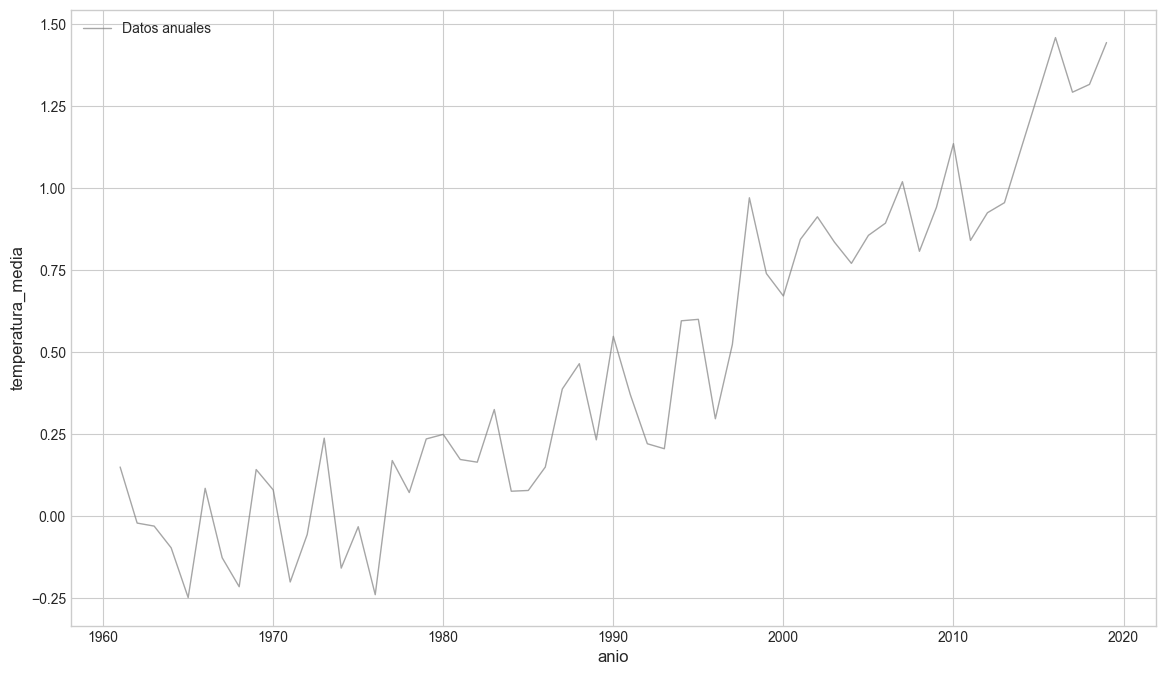

In [4]:
# Consulta para obtener temperatura media global por a√±o
query_global = """
SELECT 
    h.anio,
    AVG(h.valor) AS temperatura_media
FROM Hechos h
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'temperaturas'
AND h.periodo_id = 17  -- Periodo anual
GROUP BY h.anio
ORDER BY h.anio;
"""

df_global = pd.read_sql(query_global, conn)

# Crear gr√°fico de tendencia global
plt.figure(figsize=(14, 8))

# Graficar datos originales
sns.lineplot(data=df_global, x='anio', y='temperatura_media', linewidth=1, alpha=0.7, color='gray', label='Datos anuales')

# Aplicar suavizado para visualizar tendencia
if len(df_global) > 11:
    df_global['temperatura_suavizada'] = savgol_filter(df_global['temperatura_media'], 11, 3)
    sns.lineplot(data=df_global, x='anio', y='temperatura_suavizada', linewidth=3, color='#1f77b4', label='Tendencia (suavizado)')

# A√±adir l√≠nea de tendencia lineal
x = df_global['anio']
y = df_global['temperatura_media']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", linewidth=2, label=f'Tendencia lineal: {z[0]:.4f}¬∞C/a√±o')

# Calcular y mostrar el incremento total
temp_inicial = df_global.loc[df_global['anio'] == df_global['anio'].min(), 'temperatura_media'].values[0]
temp_final = df_global.loc[df_global['anio'] == df_global['anio'].max(), 'temperatura_media'].values[0]
incremento_total = temp_final - temp_inicial

# A√±adir anotaci√≥n con incremento total
plt.annotate(f'Incremento total: {incremento_total:.2f}¬∞C', 
            xy=(0.75, 0.05), 
            xycoords='axes fraction',
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.xlabel('A√±o')
plt.ylabel('Temperatura Media Global (¬∞C)')
plt.title('Evoluci√≥n de la Temperatura Media Global', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 3. Temperatura por Continente

Analizamos las tendencias de temperatura por continente para identificar patrones regionales.

In [ ]:
# Consulta para obtener temperatura por continente y a√±o
query_continentes = """
SELECT 
    h.anio,
    c.nombre AS continente,
    AVG(h.valor) AS temperatura_media
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Subcontinentes s ON p.subcontinente_id = s.id
JOIN Continentes c ON s.continente_id = c.id
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'temperaturas'
AND h.periodo_id = 17  -- Periodo anual
GROUP BY h.anio, c.nombre
ORDER BY h.anio;
"""

df_continentes = pd.read_sql(query_continentes, conn)

# Crear gr√°fico de l√≠neas para temperatura por continente
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_continentes, x='anio', y='temperatura_media', hue='continente', linewidth=2.5)

# A√±adir l√≠nea de tendencia global
df_temp_global = df_continentes.groupby('anio')['temperatura_media'].mean().reset_index()
sns.lineplot(data=df_temp_global, x='anio', y='temperatura_media', color='black', linewidth=3, label='Media Global')

plt.xlabel('A√±o')
plt.ylabel('Temperatura Media (¬∞C)')
plt.title('Evoluci√≥n de la Temperatura Media por Continente', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title='Continente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calcular tasas de calentamiento por continente
df_tasas = []

for continente in df_continentes['continente'].unique():
    df_cont = df_continentes[df_continentes['continente'] == continente]
    x = df_cont['anio']
    y = df_cont['temperatura_media']
    
    # Calcular regresi√≥n lineal
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # A√±adir a lista de resultados
    df_tasas.append({
        'continente': continente,
        'tasa_calentamiento': slope,
        'r_squared': r_value**2
    })

df_tasas = pd.DataFrame(df_tasas)
df_tasas = df_tasas.sort_values('tasa_calentamiento', ascending=False)

# Crear gr√°fico de barras para tasas de calentamiento
plt.figure(figsize=(12, 6))
sns.barplot(data=df_tasas, x='continente', y='tasa_calentamiento', palette='viridis')

# A√±adir etiquetas con valores
for i, v in enumerate(df_tasas['tasa_calentamiento']):
    plt.text(i, v + 0.0005, f'{v:.4f}¬∞C/a√±o', ha='center', va='bottom')

plt.xlabel('Continente')
plt.ylabel('Tasa de Calentamiento (¬∞C/a√±o)')
plt.title('Tasa de Calentamiento por Continente', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Anomal√≠as de Temperatura

Analizamos las anomal√≠as de temperatura respecto a un per√≠odo de referencia para identificar el calentamiento.

In [ ]:
# Consulta para obtener temperatura por a√±o
query_anomalias = """
SELECT 
    h.anio,
    AVG(h.valor) AS temperatura_media
FROM Hechos h
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'temperaturas'
AND h.periodo_id = 17  -- Periodo anual
GROUP BY h.anio
ORDER BY h.anio;
"""

df_anomalias = pd.read_sql(query_anomalias, conn)

# Definir per√≠odo de referencia (1961-1990, com√∫nmente usado)
anio_min_ref = 1961
anio_max_ref = 1990

# Calcular temperatura media del per√≠odo de referencia
temp_referencia = df_anomalias[
    (df_anomalias['anio'] >= anio_min_ref) & 
    (df_anomalias['anio'] <= anio_max_ref)
]['temperatura_media'].mean()

# Calcular anomal√≠as
df_anomalias['anomalia'] = df_anomalias['temperatura_media'] - temp_referencia

# Crear gr√°fico de anomal√≠as
plt.figure(figsize=(14, 8))

# Crear barras con colores seg√∫n signo de anomal√≠a
colores = ['#d62728' if x > 0 else '#1f77b4' for x in df_anomalias['anomalia']]
plt.bar(df_anomalias['anio'], df_anomalias['anomalia'], color=colores, alpha=0.7)

# A√±adir l√≠nea de tendencia
x = df_anomalias['anio']
y = df_anomalias['anomalia']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "k--", linewidth=2, label=f'Tendencia: {z[0]:.4f}¬∞C/a√±o')

# A√±adir l√≠nea de referencia en cero
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

# A√±adir l√≠neas de referencia para objetivos del Acuerdo de Par√≠s
plt.axhline(y=1.5, color='orange', linestyle='--', alpha=0.7, label='L√≠mite 1.5¬∞C (Acuerdo de Par√≠s)')
plt.axhline(y=2.0, color='red', linestyle='--', alpha=0.7, label='L√≠mite 2.0¬∞C (Acuerdo de Par√≠s)')

plt.xlabel('A√±o')
plt.ylabel(f'Anomal√≠a de Temperatura (¬∞C) respecto a {anio_min_ref}-{anio_max_ref}')
plt.title('Anomal√≠as de Temperatura Global', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 5. Relaci√≥n entre Temperatura y Emisiones de CO‚ÇÇ

Analizamos la correlaci√≥n entre las emisiones de CO‚ÇÇ y el aumento de temperatura.

In [ ]:
# Consulta para obtener temperatura y emisiones de CO‚ÇÇ por a√±o
query_temp_co2 = """
SELECT 
    h_temp.anio,
    AVG(h_temp.valor) AS temperatura_media,
    SUM(h_co2.valor) AS emisiones_co2
FROM Hechos h_temp
JOIN Indicadores i_temp ON h_temp.indicador_id = i_temp.id
JOIN Hechos h_co2 ON h_temp.anio = h_co2.anio
JOIN Indicadores i_co2 ON h_co2.indicador_id = i_co2.id
WHERE i_temp.codigo = 'temperaturas'
AND i_co2.codigo = 'emision_co2'
AND h_temp.periodo_id = 17  -- Periodo anual
GROUP BY h_temp.anio
ORDER BY h_temp.anio;
"""

df_temp_co2 = pd.read_sql(query_temp_co2, conn)

# Crear gr√°fico de dispersi√≥n para temperatura vs emisiones
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_temp_co2, x='emisiones_co2', y='temperatura_media', alpha=0.7)

# A√±adir l√≠nea de tendencia
x = df_temp_co2['emisiones_co2']
y = df_temp_co2['temperatura_media']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r-", linewidth=2)

# Calcular y mostrar coeficiente de correlaci√≥n
corr = df_temp_co2['emisiones_co2'].corr(df_temp_co2['temperatura_media'])
plt.annotate(f'Correlaci√≥n: {corr:.3f}', 
            xy=(0.05, 0.95), 
            xycoords='axes fraction',
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.xlabel('Emisiones Globales de CO‚ÇÇ (Mt)')
plt.ylabel('Temperatura Media Global (¬∞C)')
plt.title('Relaci√≥n entre Emisiones de CO‚ÇÇ y Temperatura Global', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. An√°lisis de Eventos Extremos

Analizamos la frecuencia de temperaturas extremas y su relaci√≥n con el cambio clim√°tico.

In [ ]:
# Consulta para obtener datos de desastres relacionados con temperatura
query_desastres = """
SELECT 
    h.anio,
    SUM(CASE WHEN i.codigo = 'desastres_temp_extrema' THEN h.valor ELSE 0 END) AS eventos_temp_extrema,
    SUM(CASE WHEN i.codigo = 'desastres_sequia' THEN h.valor ELSE 0 END) AS eventos_sequia,
    SUM(CASE WHEN i.codigo = 'desastres_inundacion' THEN h.valor ELSE 0 END) AS eventos_inundacion,
    AVG(CASE WHEN i.codigo = 'temperaturas' THEN h.valor ELSE NULL END) AS temperatura_media
FROM Hechos h
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo IN ('desastres_temp_extrema', 'desastres_sequia', 'desastres_inundacion', 'temperaturas')
AND (i.codigo != 'temperaturas' OR h.periodo_id = 17)  -- Periodo anual para temperaturas
GROUP BY h.anio
ORDER BY h.anio;
"""

df_desastres = pd.read_sql(query_desastres, conn)

# Crear gr√°fico de l√≠neas para eventos extremos
plt.figure(figsize=(14, 8))

# Crear gr√°fico de barras apiladas para eventos
width = 0.8
bottom_data = np.zeros(len(df_desastres))

# Eventos de temperatura extrema
plt.bar(df_desastres['anio'], df_desastres['eventos_temp_extrema'], width, label='Temperatura Extrema', bottom=bottom_data, alpha=0.7, color='#d62728')
bottom_data = bottom_data + df_desastres['eventos_temp_extrema']

# Eventos de sequ√≠a
plt.bar(df_desastres['anio'], df_desastres['eventos_sequia'], width, label='Sequ√≠a', bottom=bottom_data, alpha=0.7, color='#ff7f0e')
bottom_data = bottom_data + df_desastres['eventos_sequia']

# Eventos de inundaci√≥n
plt.bar(df_desastres['anio'], df_desastres['eventos_inundacion'], width, label='Inundaci√≥n', bottom=bottom_data, alpha=0.7, color='#1f77b4')

# A√±adir l√≠nea de temperatura
ax2 = plt.twinx()
ax2.plot(df_desastres['anio'], df_desastres['temperatura_media'], 'k-', linewidth=2, label='Temperatura Media')

# Configurar ejes y leyendas
plt.xlabel('A√±o')
plt.ylabel('N√∫mero de Eventos')
ax2.set_ylabel('Temperatura Media Global (¬∞C)')
plt.title('Eventos Clim√°ticos Extremos y Temperatura Global', fontsize=16)
plt.grid(True, alpha=0.3)

# Combinar leyendas de ambos ejes
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Calcular correlaciones entre temperatura y eventos extremos
corr_temp_extrema = df_desastres['temperatura_media'].corr(df_desastres['eventos_temp_extrema'])
corr_sequia = df_desastres['temperatura_media'].corr(df_desastres['eventos_sequia'])
corr_inundacion = df_desastres['temperatura_media'].corr(df_desastres['eventos_inundacion'])

print("Correlaciones entre temperatura media y eventos extremos:")
print(f"Temperatura extrema: {corr_temp_extrema:.3f}")
print(f"Sequ√≠a: {corr_sequia:.3f}")
print(f"Inundaci√≥n: {corr_inundacion:.3f}")

## 7. Conclusiones

A partir del an√°lisis realizado, podemos extraer las siguientes conclusiones sobre el impacto del cambio clim√°tico en la temperatura global:

1. **Tendencia de calentamiento inequ√≠voca**: Los datos muestran un aumento sostenido de la temperatura media global, con una tendencia lineal positiva estad√≠sticamente significativa.

2. **Aceleraci√≥n del calentamiento**: La tasa de calentamiento se ha incrementado en las √∫ltimas d√©cadas, con anomal√≠as de temperatura cada vez m√°s pronunciadas respecto al per√≠odo preindustrial.

3. **Variabilidad regional**: El calentamiento no es uniforme en todo el planeta. Algunas regiones, especialmente las polares y continentales, experimentan un calentamiento m√°s acelerado que las regiones oce√°nicas.

4. **Correlaci√≥n con emisiones de CO‚ÇÇ**: Existe una fuerte correlaci√≥n positiva entre las emisiones globales de CO‚ÇÇ y el aumento de temperatura, respaldando la teor√≠a del efecto invernadero antropog√©nico.

5. **Aumento de eventos extremos**: Se observa un incremento en la frecuencia de eventos clim√°ticos extremos (olas de calor, sequ√≠as, inundaciones) que correlaciona con el aumento de temperatura global.

6. **Proyecciones preocupantes**: De continuar las tendencias actuales, es probable que se superen los umbrales cr√≠ticos de 1.5¬∞C y 2¬∞C establecidos en el Acuerdo de Par√≠s en las pr√≥ximas d√©cadas, con consecuencias potencialmente graves para los ecosistemas y sociedades humanas.

7. **Aumentos de temperaturas por regiones**: Como se puede observar en los mapas regfionales del apartado numero 0, las regiones o paises con mayor aumento de temperaturas en la ultima decada los podemos encontrar en asia, america y eurpa, paises los cuales han contado y estan contando con indice de desarrollo muy elevado y paises en crecimiento, por lo qie podemos concluir que los paises en vias de desarrollo y los mas desarrollados en su mayoria son los que mas tienden a aumentar sus temperaturas medias a√±o tras a√±o y esto seguira sucediendo si no se transiciona a un mayor empleo y uso de energias renovables y verdes.

Estos hallazgos subrayan la urgencia de implementar medidas de mitigaci√≥n ambiciosas para reducir las emisiones de gases de efecto invernadero, as√≠ como estrategias de adaptaci√≥n para hacer frente a los cambios clim√°ticos ya inevitables.

In [ ]:
# Cerrar conexi√≥n a la base de datos
conn.close()